In [1]:
import numpy as np
import pandas as pd
import random
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import StratifiedKFold,KFold, train_test_split
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
from scipy.stats import norm, skew, rankdata
from sklearn.preprocessing import LabelEncoder

import os
print(os.listdir("../input"))

os.environ['NEPTUNE_API_TOKEN'] = "your api key"

import neptune
import gc

neptune.init(project_qualified_name='your project')

random_state = 42
np.random.seed(random_state)

['aug_test.csv', 'aug_X_train.csv', 'aug_X_valid.csv', 'aug_y_train.csv', 'aug_y_valid.csv', 'corr_mat.csv', 'Private_LB.csv', 'Public_LB.csv', 'sample_submission.csv', 'statistics.csv', 'statistics_0.csv', 'synthetic_samples_indexes.csv', 'test.csv', 'train.csv']


In [2]:
#Load the Data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

private_lb = pd.read_csv("../input/Private_LB.csv")
public_lb = pd.read_csv("../input/Public_LB.csv")
synthetic = pd.read_csv("../input/synthetic_samples_indexes.csv")

private_lb = private_lb.rename(index=str, columns={"Private_LB": "index"})
public_lb = public_lb.rename(index=str, columns={"Public_LB": "index"})
synthetic = synthetic.rename(index=str, columns={"synthetic_samples_indexes": "index"})

true = public_lb.append(private_lb, ignore_index=True)

In [3]:
def add_p_n(df, drop_list):
    
    df_ = df.drop(drop_list, axis=1)
    df_list = df_.values

    positives = np.zeros(df.shape[0])
    negatives = np.zeros(df.shape[0])
    abs_ = np.zeros(df.shape[0])

    for i in range(df_list.shape[0]):
        positive = np.where(df_list[i]>0,df_list[i], 0)
        negative = np.where(df_list[i]<0, df_list[i], 0)
        positives[i] = len(set(positive))-1
        negatives[i] = len(set(negative))-1
        abs_[i] = np.sum(np.abs(df_list[i])-df_list[i])

    df['positive'] = positives
    #df['negative'] = negatives
    #df['ratio'] = positives/negatives
    #df['abs_'] = abs_
    
    #df = df.drop(['positive', 'negative'], axis=1)
    
    return df

In [4]:
#train = add_p_n(train, ['ID_code', 'target'])
#test_synthetic = add_p_n(test_synthetic, ['ID_code'])
#test_true = add_p_n(test_true, ['ID_code'])

In [5]:
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)
    
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        tr[col] = tr[col]*(-1)
        te[col] = te[col]*(-1)
    return tr,te

def scale(df, cols):
    for var in cols:
        mean = df[var].mean()
        std = df[var].std()
        df[var] = df[var].apply(lambda x:(x-mean)/std)
        
    return df

def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

def get_pdfs(tr):
    y = []
    for i in range(200):
        name = 'var_%d'%i
        res = get_pdf(tr,name)
        y.append(res)
    return np.vstack(y)

def print_corr(corr_mat,col,bar=0.97):
    cols = corr_mat.loc[corr_mat[col]>bar,col].index.values
    cols_ = ['var_%s'%(i.split('_')[-1]) for i in cols]
    return cols

In [6]:
#train, test = reverse(train, test)

test_true = test.iloc[true["index"], :]
test_synthetic = test.iloc[synthetic["index"], :]

del private_lb, public_lb, synthetic, true
gc.collect()

14

In [7]:
feature = [c for c in train.columns if c not in ['ID_code', 'target']]

In [8]:
#train = scale(train, feature)
#test_true = scale(test_true, feature)
#test_synthetic = scale(test_synthetic, feature)
#test = pd.concat([test_true, test_synthetic], axis=0).sort_index()

In [9]:
from scipy.stats import boxcox

def Bigger(x, count, thres):
    if count > thres:
        return x
    return 0

def Smaller(x, count, thres):
    if count > thres:
        return 0
    return x


def is_Big(x, count, thres):
    if count > thres:
        return 1
    return 0

def processing(df, cols, add_0, add_1, no_add_1=True):
    
    total_cols = cols.copy()
    total_cols.append('ID_code')
    if (no_add_1):
        tmp = pd.concat([df[total_cols], add_0[total_cols]], axis=0)
    else:
        tmp = pd.concat([df[total_cols], add_0[total_cols], add_1[total_cols]], axis=0)
    size = tmp.shape[0]

    for var in cols:
        
        print(var)
        #mode = tmp[var].mode()
        #std = tmp[var].std()
        #tmp[var+'_dis'] = tmp[var].apply(lambda x:abs(x-mode)/std)
        tmp[var+'_count'] = tmp.groupby([var])['ID_code'].transform('count')
        #df[var+'_dis'] = tmp.iloc[:df.shape[0]][var+'_dis']
        df[var+'_count'] = tmp.iloc[:df.shape[0]][var+'_count']
        max_ = tmp[var+'_count'].max()
        min_ = tmp[var+'_count'].min()
        #df[var+'_count'] = df[var+'_count'].apply(lambda x:1 if (abs(x-max_)/(max_-min_)<=0.01)or\
                                                  #(abs(x-min_)/(max_-min_)<=0.01) else 0)
        df[var+'_count'] = df[var+'_count'].apply(lambda x:min((abs(x-max_)/(max_-min_)),\
                                                  (abs(x-min_)/(max_-min_))))
        #df[var+'_cp'] = rankdata(df[var+'_count']).astype('float32')
        #df[var+'_cnp'] = norm.cdf(df[var+'_count']).astype('float32')
        
        #df = df.drop(var+'_count', axis=1)
    return df



def processing_new(df, cols, add_0, add_1):
    
    for feature in cols:
        print(feature)
        
        bin_ = 4000
        hist_random, bin_edges_random = np.histogram(df[feature], bins=bin_, density=True)
        hist_random_0, bin_edges_random_0 = np.histogram(add_0[feature], bins=bin_, density=True)
        hist_random_1, bin_edges_random_1 = np.histogram(add_1[feature], bins=bin_, density=True)
        
        def get_distance(x, hist_random, hist_random_0, hist_random_1, bin_edges_random, bin_edges_random_0, \
                        bin_edges_random_1):
            if((np.searchsorted(bin_edges_random_1,x)-1<bin_)and(np.searchsorted(bin_edges_random_0,x)-1<bin_)):
                
                return abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -hist_random_0[np.searchsorted(bin_edges_random_0,x)-1])\
                             +abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -hist_random_1[np.searchsorted(bin_edges_random_1,x)-1])
            
            elif ((np.searchsorted(bin_edges_random_1,x)-1>=bin_)and(np.searchsorted(bin_edges_random_0,x)-1<bin_)):
                
                return abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -hist_random_0[np.searchsorted(bin_edges_random_0,x)-1])\
                             +abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -0)
            
            elif ((np.searchsorted(bin_edges_random_1,x)-1<bin_)and(np.searchsorted(bin_edges_random_0,x)-1>=bin_)):
                
                return abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -0)\
                             +abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -hist_random_1[np.searchsorted(bin_edges_random_1,x)-1])
            
            else:
                
                return abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -0)\
                             +abs(hist_random[np.searchsorted(bin_edges_random,x)-1]\
                             -0)
                

        df['fe_'+feature] = df[feature].apply(lambda x: get_distance(x, hist_random, hist_random_0, \
                                            hist_random_1, bin_edges_random, bin_edges_random_0, \
                                            bin_edges_random_1))
         
    return df

def processing_new_new(df, cols, add_0, add_1):
    
    for var in cols:
        print(var)
        total_cols = [var]
        total_cols.append('ID_code')
        tmp = pd.concat([df[total_cols]], axis=0)

        tmp['random_{}'.format(var)] = np.random.normal(tmp[var].mean(), tmp[var].std(), tmp.shape[0]).round(4)
        var_counts = pd.DataFrame(tmp.groupby(var)['ID_code'].count()).reset_index()
        var_counts_random = pd.DataFrame(tmp.groupby('random_{}'.format(var))['ID_code'].count()).reset_index()
        merged_counts = pd.merge(var_counts, var_counts_random, left_on=var, right_on='random_{}'.format(var))
        merged_counts['diff'] = merged_counts['ID_code_x'] - merged_counts['ID_code_y']
        tmp['{}_diff_normal_dist'.format(var)] = tmp.merge(merged_counts[[var,'diff']], how='left')['diff']
        df['{}_diff_normal_dist'.format(var)] = tmp.iloc[:df.shape[0]]['{}_diff_normal_dist'.format(var)]/df[var]
        df['{}_diff_normal_dist'.format(var)] = df['{}_diff_normal_dist'.format(var)].apply(lambda x:1 \
                                                                                if abs(x)<0.1 else 0)
    return df

def processing_new_new_new(df, cols):
    
    for feature in cols:
        print(feature)
        
        bin_ = 1000
        hist_random, bin_edges_random = np.histogram(df[feature], bins=bin_, density=True)

        def get_gradient(x, hist_random, bin_edges_random):

            if((np.searchsorted(bin_edges_random,x)-1!=0)and(np.searchsorted(bin_edges_random,x)-1!=bin_-1)):

                t_2 = hist_random[np.searchsorted(bin_edges_random,x)]
                t_1 = hist_random[np.searchsorted(bin_edges_random,x)-1]
                t_0 = hist_random[np.searchsorted(bin_edges_random,x)-2]

                if(t_1-t_0==0):
                    if(t_2-t_1==0):
                        return 1
                    else:
                        return 100

                return (t_2-t_1)/(t_1-t_0)

            if(np.searchsorted(bin_edges_random,x)-1==0): 
                return 100

            if(np.searchsorted(bin_edges_random,x)-1==bin_-1):
                return -100

        df['gradient_'+feature] = df[feature].apply(lambda x: get_gradient(x, hist_random, bin_edges_random))
         
    return df

In [37]:
#important = ['var_81', 'var_21', 'var_174', 'var_139', 'var_12', 'var_6', 'var_0', 'var_184', \
             #'var_179', 'var_146', 'var_53', 'var_76', 'var_108', 'var_126']
#important = ['var_12', 'var_108', 'var_126']
important = [c for c in train.columns if c not in ['ID_code', 'target']]

remove = ['var_61','var_158','var_136','var_185','var_96','var_182','var_19',\
 'var_47', 'var_183', 'var_140', 'var_178', 'var_39', 'var_134', 'var_54',\
 'var_100', 'var_159', 'var_101', 'var_60', 'var_30', 'var_199', 'var_65',\
 'var_142', 'var_7', 'var_138', 'var_160', 'var_24', 'var_14', 'var_10', 'var_38',\
 'var_128', 'var_120', 'var_20', 'var_58', 'var_8', 'var_97', 'var_29', 'var_175',\
 'var_85', 'var_62', 'var_73', 'var_41', 'var_55', 'var_74', 'var_90', 'var_11',\
 'var_35', 'var_196', 'var_151', 'var_156', 'var_153', 'var_37', 'var_117',\
 'var_45', 'var_124', 'var_16', 'var_72', 'var_27', 'var_3', 'var_186', 'var_17',\
 'var_143', 'var_193', 'var_104', 'var_77', 'var_67', 'var_31', 'var_168',\
 'var_176', 'var_88', 'var_194', 'var_69', 'var_157', 'var_118', 'var_84',\
 'var_4', 'var_171', 'var_111', 'var_36', 'var_115', 'var_189', 'var_63',\
 'var_113', 'var_51', 'var_141', 'var_152', 'var_167', 'var_172', 'var_180',\
 'var_129', 'var_48', 'var_78', 'var_42', 'var_149', 'var_150', 'var_57',\
 'var_87', 'var_46', 'var_21', 'var_187', 'var_18']

remove_list = remove[:20] + ['ID_code', 'target']

#important = [c for c in train.columns if c not in remove_list]

In [11]:
#test_true = processing_new_new(test_true, important, train, test_synthetic)
#test_synthetic = processing_new_new(test_synthetic, important, train, test_true)
test_true = processing(test_true, important, train, test_synthetic, True)
test_synthetic = processing(test_synthetic, important, train, test_true, True)
test = pd.concat([test_true, test_synthetic], axis=0).sort_index()

test['id'] = test['ID_code'].apply(lambda x : int(x[5:]))
test = test.sort_values(by='id').reset_index(drop=True)

#del test_synthetic
gc.collect()

var_0
var_1
var_2
var_3
var_4
var_5
var_6
var_7
var_8
var_9
var_10
var_11
var_12
var_13
var_14
var_15
var_16
var_17
var_18
var_20
var_21
var_22
var_23
var_24
var_25
var_26
var_27
var_28
var_29
var_31
var_32
var_33
var_34
var_35
var_36
var_37
var_38
var_40
var_41
var_42
var_43
var_44
var_45
var_46
var_48
var_49
var_50
var_51
var_52
var_53
var_55
var_56
var_57
var_58
var_59
var_62
var_63
var_64
var_65
var_66
var_67
var_68
var_69
var_70
var_71
var_72
var_73
var_74
var_75
var_76
var_77
var_78
var_79
var_80
var_81
var_82
var_83
var_84
var_85
var_86
var_87
var_88
var_89
var_90
var_91
var_92
var_93
var_94
var_95
var_97
var_98
var_99
var_102
var_103
var_104
var_105
var_106
var_107
var_108
var_109
var_110
var_111
var_112
var_113
var_114
var_115
var_116
var_117
var_118
var_119
var_120
var_121
var_122
var_123
var_124
var_125
var_126
var_127
var_128
var_129
var_130
var_131
var_132
var_133
var_135
var_137
var_138
var_139
var_141
var_142
var_143
var_144
var_145
var_146
var_147
var_148
var_149
var_15

28

In [12]:
#train = processing_new(train, important, test_true, test_synthetic)

In [13]:
def plot_hist_target(df, feature):
    negData = df.loc[df['target'] == 0][feature]
    posData = df.loc[df['target'] == 1][feature]

    fig, ax = plt.subplots(ncols = 1, figsize=(20,5))

    fig.suptitle(feature)
    outs1, outs2, outs3 = ax.hist([negData, posData], 
                                  bins=30, 
                                  density = True, 
                                  histtype='step', 
                                  label=("target 0", "target 1"),
                                  linewidth=3)
    ax.set_xticks(outs2)
    ax.xaxis.grid(True)
    handles, labels=ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    fig.show()
    plt.show()

In [14]:
#plot_hist_target(train, 'fe_var_12')

In [15]:
test = test.drop('id', axis=1)
#test.to_csv("aug_test.csv", index=False)
test.head(30)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_189_count,var_190_count,var_191_count,var_192_count,var_193_count,var_194_count,var_195_count,var_196_count,var_197_count,var_198_count
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,0.464286,0.176471,0.066667,0.035714,0.461538,0.058824,0.083333,0.266667,0.129032,0.250000
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,0.321429,0.117647,0.400000,0.321429,0.153846,0.176471,0.250000,0.133333,0.290323,0.187500
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,0.285714,0.117647,0.266667,0.285714,0.230769,0.176471,0.125000,0.066667,0.161290,0.187500
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,0.333333,0.153846,0.076923,0.272727,0.200000,0.230769,0.150000,0.111111,0.333333,0.461538
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,0.428571,0.176471,0.133333,0.214286,0.384615,0.235294,0.458333,0.066667,0.161290,0.250000
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,...,0.214286,0.235294,0.133333,0.071429,0.153846,0.235294,0.166667,0.000000,0.161290,0.437500
6,test_6,8.4624,-6.1065,7.3603,8.2627,12.0104,-7.2073,4.1670,13.0809,-4.3004,...,0.142857,0.000000,0.266667,0.178571,0.000000,0.176471,0.375000,0.400000,0.451613,0.187500
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,...,0.111111,0.307692,0.153846,0.363636,0.200000,0.076923,0.050000,0.111111,0.148148,0.000000
8,test_8,6.9856,0.8402,13.7161,4.7749,8.6784,-13.7607,4.3386,14.5843,2.5883,...,0.321429,0.235294,0.066667,0.464286,0.076923,0.470588,0.375000,0.200000,0.451613,0.187500
9,test_9,10.3811,-6.9348,14.6690,9.0941,11.9058,-10.8018,3.4508,20.2816,-1.4112,...,0.321429,0.117647,0.000000,0.285714,0.384615,0.176471,0.291667,0.133333,0.419355,0.437500


In [16]:
#corrs = test.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
#corrs = corrs[corrs['level_0'] < corrs['level_1']]
#corrs.tail(30)

In [17]:
#del corrs
#gc.collect()

In [18]:
target = train['target']
#train = train.drop(['target'], axis=1)
test = test.drop("ID_code", axis=1)

In [19]:
# https://stackoverflow.com/questions/50554272/randomly-shuffle-items-in-each-row-of-numpy-array
def disarrange(a, axis=-1):
    """
    Shuffle `a` in-place along the given axis.

    Apply numpy.random.shuffle to the given axis of `a`.
    Each one-dimensional slice is shuffled independently.
    """
    b = a.swapaxes(axis, -1)
    # Shuffle `b` in-place along the last axis.  `b` is a view of `a`,
    # so `a` is shuffled in place, too.
    shp = b.shape[:-1]
    for ndx in np.ndindex(shp):
        np.random.shuffle(b[ndx])
    return

def augment_fast2(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [38]:
NAME = 'baseline'

param__ = {
'bagging_freq':6,
'bagging_fraction': 0.535,
'boost_from_average':'false',
'boost': 'gbdt',
'feature_fraction': 0.041,
'learning_rate': 0.0083,
'max_depth': -1,
'metric':'auc',
'min_data_in_leaf': 100,
'min_sum_hessian_in_leaf': 10.0,
'num_leaves': 13,
'num_threads': 8,
'tree_learner': 'serial',
'objective': 'binary', 
'verbosity': -1
}

param_ = {'num_leaves': 16,
    'min_data_in_leaf': 42,
    'tree_learner': 'serial',
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'bagging_freq': 2,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.05,
    'bagging_seed': 11,
    'reg_alpha': 1.728910519108444,
    'reg_lambda': 4.9847051755586085,
    'random_state': 42,
    'metric': 'auc',
    'verbosity': -1,
    # 'subsample': 0.81,
    'min_gain_to_split': 7,
    # 'min_child_weight': 19.428902804238373,
    'num_threads': -1,
    'min_sum_hessian_in_leaf': 10.0,
    'boost_from_average':'false'}


param = {
    'bagging_freq':1,
    'bagging_fraction': 0.8,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 10.0,
    #'reg_alpha': 1.728910519108444,
    #'reg_lambda': 4.9847051755586085,
    #"lambda_l1" : 8.631,
    #"lambda_l2" : 4.44,
    'num_leaves': 8,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'device': 'gpu',
    'gpu_platform_id': 1,
    'gpu_device_id': 1,
    'verbosity': -1
}

train_params = {
    'num_boosting_rounds': 1000000,
    'early_stopping_rounds' : 4000,
    'verbose_eval': 5000
}

params = {**param, **train_params}


In [39]:
def neptune_monitor(prefix):
    def callback(env):
        for name, loss_name, loss_value, _ in env.evaluation_result_list:
            channel_name = '{}{}_{}'.format(prefix, name, loss_name)
            neptune.send_metric(channel_name, x=env.iteration, y=loss_value)
    return callback


def plot_prediction_distribution(y_true, y_pred, ax):
    df = pd.DataFrame({'prediction': y_pred, 'ground_truth': y_true})
    
    sns.distplot(df[df['ground_truth'] == 0]['prediction'], label='negative', ax=ax)
    sns.distplot(df[df['ground_truth'] == 1]['prediction'], label='positive', ax=ax)

    ax.legend(prop={'size': 16}, title = 'Labels')

In [40]:
with neptune.create_experiment(name=NAME,
                               params=params):
    
    feature_importance_df = pd.DataFrame()

    print('Light GBM Model')
    
    ori_features = [c for c in train.columns if c not in ['target']]
    
    def resort_train(df):
        df['id'] = df['ID_code'].apply(lambda x : int(x[6:]))
        df = df.sort_values(by='id').reset_index(drop=True)
        df = df.drop(['ID_code', 'id'], axis=1)
        
        return df
    
    
    #important = ['var_12', 'var_108', 'var_126']
    X_train, X_valid, y_train, y_valid = train_test_split(train[ori_features], train[['ID_code', 'target']], \
                                                      test_size=0.2, random_state=42)
    
    predictions = np.zeros(y_valid.shape[0])

    #X_tr, y_tr = augment_fast2(X_train.values, y_train.values)
    #X_tr = pd.DataFrame(X_tr)

    #print(y_tr)
    #y_tr[y_tr==1] = 0.9
    #y_tr[y_tr==0] = 0.1
    #y_tr += np.random.normal(0, 0.01, y_tr.shape)
    #y_tr[y_tr<0] = 0
    #y_tr[y_tr>1]: I just have a big jump in the LB when I try to construct features besides original distribution. This seems to be the right direction :D = 1
    
    #cat_features = [i+"_map" for i in important]
    
    
    X_train = processing(X_train, important, test_true, X_valid, False)
    X_valid = processing(X_valid, important, test_true, X_train, False)
    
    #y_train = y_train.drop(['ID_code'], axis=1)
    #y_valid = y_valid.drop(['ID_code'], axis=1)
    
    #X_train = processing_new_new(X_train, important, test_true, test_synthetic)
    #X_valid = processing_new_new(X_valid, important, test_true, test_synthetic)

    X_train = resort_train(X_train)
    y_train = resort_train(y_train)
    X_valid = resort_train(X_valid)
    y_valid = resort_train(y_valid)

    features = [c for c in X_train.columns if c not in ['ID_code', 'target']]

    trn_data = lgb.Dataset(X_train[features], label=y_train)
    val_data = lgb.Dataset(X_valid[features], label=y_valid)
    
    #trn_data = lgb.Dataset(X_train, label=y_train)
    #val_data = lgb.Dataset(X_valid, label=y_valid)

    monitor = neptune_monitor(prefix='training')

    clf = lgb.train(param, trn_data, train_params['num_boosting_rounds'], \
                    valid_sets = [trn_data, val_data], verbose_eval = train_params['verbose_eval'], \
                    early_stopping_rounds=train_params['early_stopping_rounds'], callbacks=[monitor])

    
    predictions = clf.predict(X_valid, num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)



    print("CV score: {:<8.5f}".format(roc_auc_score(y_valid, predictions)))
    neptune.send_metric('roc_auc', roc_auc_score(y_valid, predictions))
    
    

Light GBM Model
var_0
var_1
var_2
var_3
var_4
var_5
var_6
var_7
var_8
var_9
var_10
var_11
var_12
var_13
var_14
var_15
var_16
var_17
var_18
var_19
var_20
var_21
var_22
var_23
var_24
var_25
var_26
var_27
var_28
var_29
var_30
var_31
var_32
var_33
var_34
var_35
var_36
var_37
var_38
var_39
var_40
var_41
var_42
var_43
var_44
var_45
var_46
var_47
var_48
var_49
var_50
var_51
var_52
var_53
var_54
var_55
var_56
var_57
var_58
var_59
var_60
var_61
var_62
var_63
var_64
var_65
var_66
var_67
var_68
var_69
var_70
var_71
var_72
var_73
var_74
var_75
var_76
var_77
var_78
var_79
var_80
var_81
var_82
var_83
var_84
var_85
var_86
var_87
var_88
var_89
var_90
var_91
var_92
var_93
var_94
var_95
var_96
var_97
var_98
var_99
var_100
var_101
var_102
var_103
var_104
var_105
var_106
var_107
var_108
var_109
var_110
var_111
var_112
var_113
var_114
var_115
var_116
var_117
var_118
var_119
var_120
var_121
var_122
var_123
var_124
var_125
var_126
var_127
var_128
var_129
var_130
var_131
var_132
var_133
var_134
var_135
var_13

KeyboardInterrupt: 

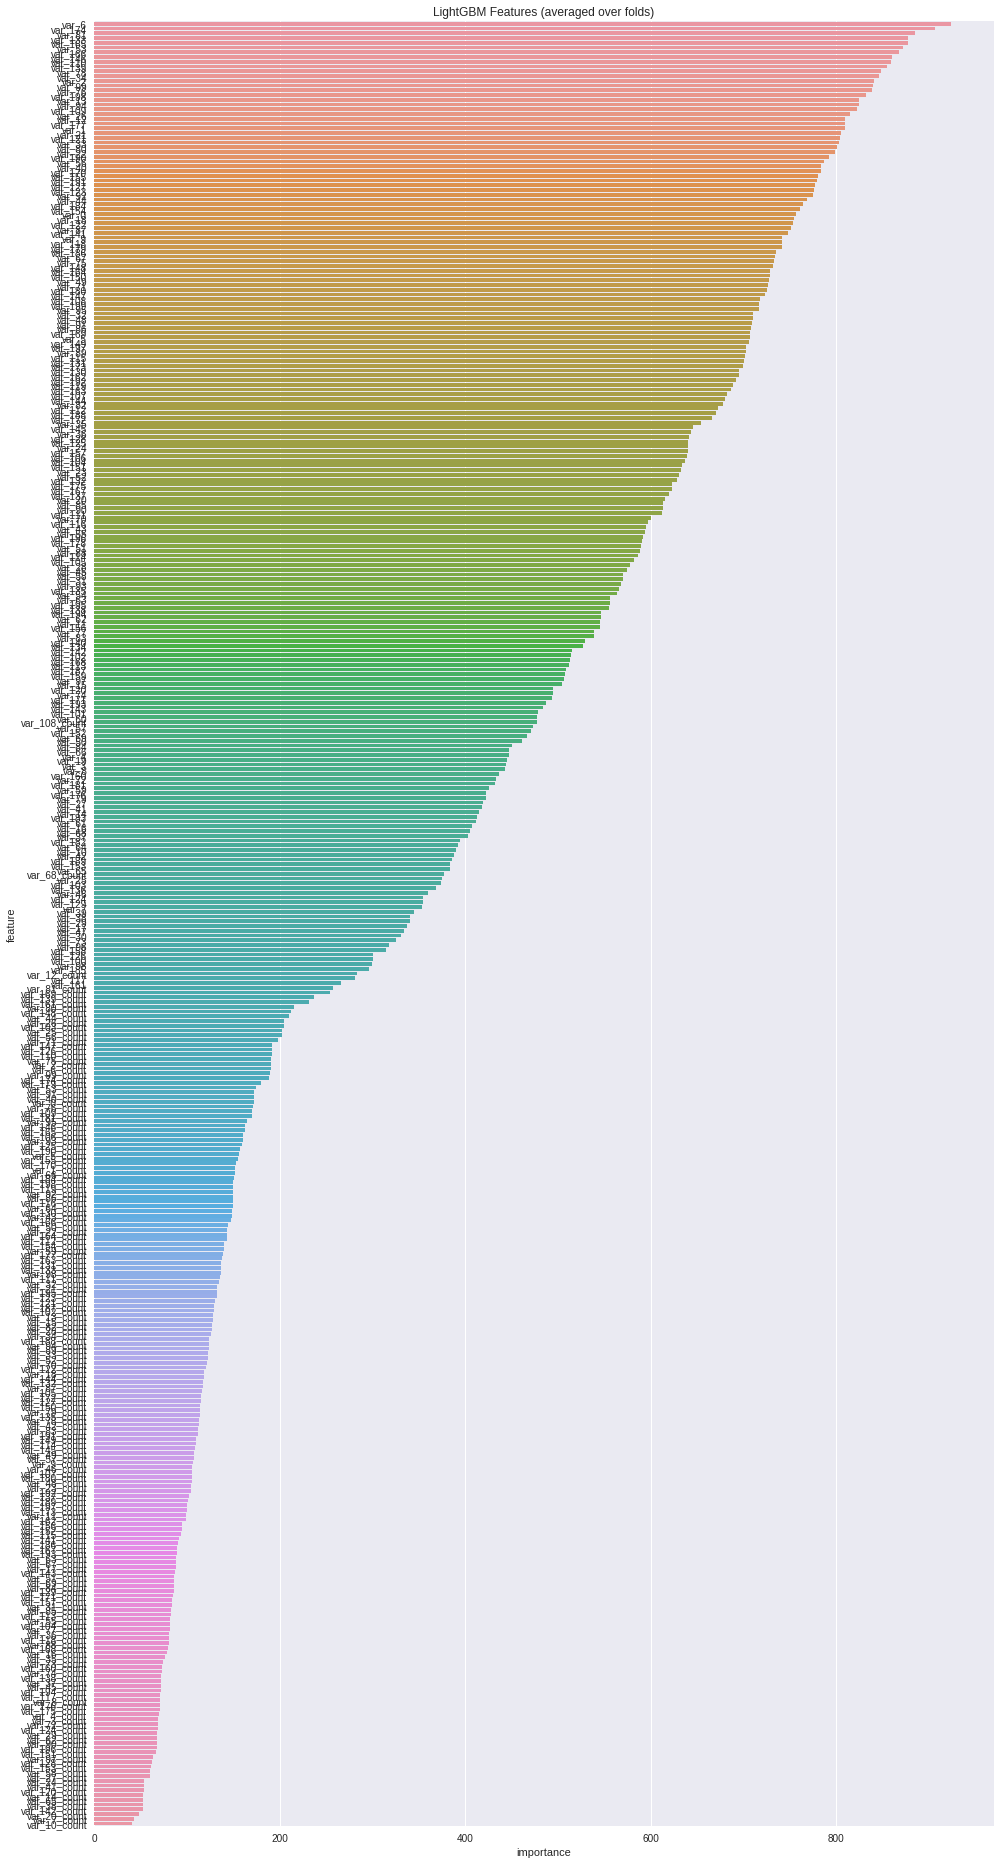

In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [24]:
remove_list = best_features.sort_values(by="importance")['feature'].head(100).values
for i in range(len(remove_list)):
    remove_list[i] = remove_list[i][:-6]
print(remove_list)

['var_10' 'var_7' 'var_20' 'var_65' 'var_14' 'var_142' 'var_38' 'var_120'
 'var_24' 'var_41' 'var_58' 'var_27' 'var_153' 'var_128' 'var_97'
 'var_151' 'var_196' 'var_62' 'var_90' 'var_29' 'var_124' 'var_3' 'var_72'
 'var_4' 'var_176' 'var_175' 'var_117' 'var_8' 'var_37' 'var_138' 'var_45'
 'var_194' 'var_160' 'var_74' 'var_73' 'var_35' 'var_16' 'var_168'
 'var_118' 'var_36' 'var_88' 'var_104' 'var_55' 'var_77' 'var_113'
 'var_85' 'var_157' 'var_31' 'var_171' 'var_129' 'var_51' 'var_69'
 'var_84' 'var_143' 'var_67' 'var_17' 'var_63' 'var_193' 'var_167'
 'var_186' 'var_141' 'var_115' 'var_156' 'var_152' 'var_162' 'var_11'
 'var_173' 'var_197' 'var_189' 'var_137' 'var_23' 'var_192' 'var_48'
 'var_46' 'var_180' 'var_107' 'var_9' 'var_57' 'var_49' 'var_145'
 'var_149' 'var_114' 'var_191' 'var_83' 'var_78' 'var_42' 'var_150'
 'var_135' 'var_79' 'var_172' 'var_127' 'var_105' 'var_132' 'var_87'
 'var_18' 'var_144' 'var_122' 'var_70' 'var_33' 'var_52']


In [25]:
X_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_189_count,var_190_count,var_191_count,var_192_count,var_193_count,var_194_count,var_195_count,var_196_count,var_197_count,var_198_count
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,0.259259,0.153846,0.461538,0.363636,0.3,0.384615,0.20,0.444444,0.481481,0.307692
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,0.481481,0.461538,0.307692,0.363636,0.1,0.230769,0.15,0.333333,0.259259,0.384615
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,0.074074,0.230769,0.307692,0.227273,0.1,0.076923,0.05,0.222222,0.407407,0.230769
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,0.222222,0.076923,0.153846,0.227273,0.3,0.230769,0.35,0.444444,0.111111,0.076923
4,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,0.074074,0.000000,0.230769,0.045455,0.4,0.384615,0.30,0.111111,0.222222,0.153846


In [26]:
num_sub = 50
print('Saving the Submission File')
predictions = clf.predict(test, num_iteration=clf.best_iteration)
test_ = pd.read_csv('../input/test.csv')
sub = pd.DataFrame({"ID_code": test_.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)

Saving the Submission File


In [27]:
CV score: 0.91050 

SyntaxError: invalid syntax (<ipython-input-27-40acdbae2ef9>, line 1)